In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:13<00:00, 62.1MB/s]
100% 1.33G/1.33G [00:13<00:00, 105MB/s] 


In [ ]:
import zipfile

with zipfile.ZipFile("/content/celeba-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [48]:
# prompt: IMPORT UNTUK ALEXNET MODEL

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
# File paths
BASIC_PATH = "/content/dataset"
IMG_PATH = os.path.join(BASIC_PATH, 'img_align_celeba/img_align_celeba')
FEATURE_PATH = os.path.join(BASIC_PATH, 'list_attr_celeba.csv')

In [50]:
# Membaca jumlah gambar di direktori
n_images = len(os.listdir(IMG_PATH))
print("Total Images in the Dataset: ", n_images)

Total Images in the Dataset:  202599


In [51]:
# Membaca file csv atribut ke dalam dataframe
df = pd.read_csv(FEATURE_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Mengubah nilai kolom 'Male' menjadi kategorik
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

<ipython-input-51-d8b3b1417418>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Female' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Male'] == -1,'Male'] = "Female"


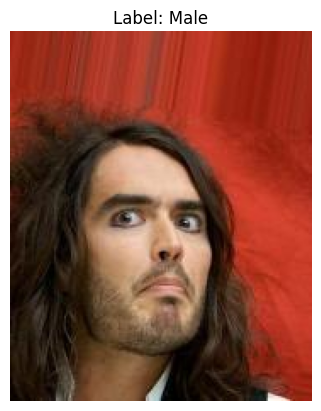

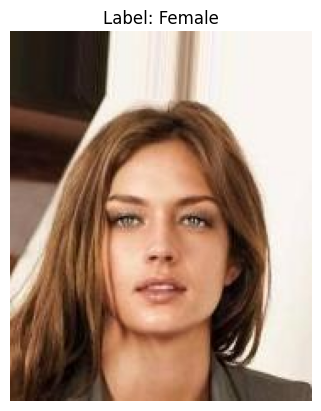

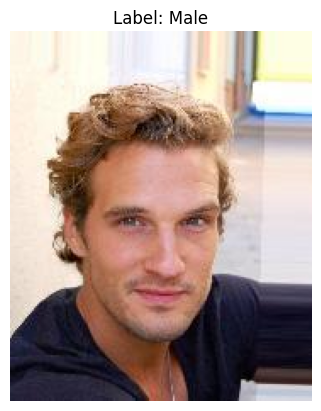

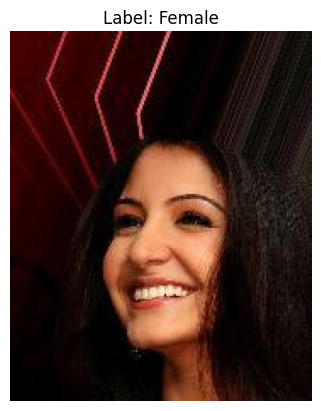

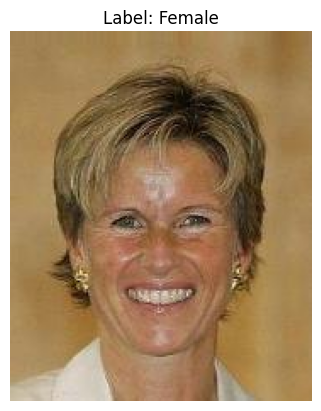

In [52]:
# prompt: Sample Images

def show_sample_images(df, img_path, num_images=5):
  """
  Displays sample images with their corresponding labels.

  Args:
    df: Pandas DataFrame containing image IDs and labels.
    img_path: Path to the directory containing images.
    num_images: Number of sample images to display.
  """
  for i in range(num_images):
    image_id = df['image_id'][i]
    image_path = os.path.join(img_path, image_id)
    label = df['Male'][i]

    try:
      img = mpimg.imread(image_path)
      plt.imshow(img)
      plt.title(f"Label: {label}")
      plt.axis('off')
      plt.show()
    except FileNotFoundError:
      print(f"Image not found: {image_path}")

# Example usage
show_sample_images(df, IMG_PATH)

In [53]:
# prompt: # Get the category distribution.
category_counts = df['Male'].value_counts()
print("Category Distribution:")
print(category_counts)

Category Distribution:
Male
Female    1442
Male      1058
Name: count, dtype: int64


In [54]:
# prompt: Get the indices of the higher category indices images. and  # Drop the extra rows of female images to fix class imbalance problem.

# Get the indices of the higher category (e.g., 'Male')
higher_category_indices = df[df['Male'] == 'Male'].index.tolist()

# Drop the extra rows of female images to fix class imbalance problem.
# (You might want to adjust the number of dropped rows or use a different strategy based on your specific needs).
num_to_drop = len(df[df['Male'] == 'Female']) - len(df[df['Male'] == 'Male'])

if num_to_drop > 0:
  female_indices = df[df['Male'] == 'Female'].index.tolist()
  indices_to_drop = np.random.choice(female_indices, size=num_to_drop, replace=False)
  df = df.drop(indices_to_drop)

# Verify the updated category counts
category_counts = df['Male'].value_counts()
print("Updated Category Distribution:")
print(category_counts)

Updated Category Distribution:
Male
Male      1058
Female    1058
Name: count, dtype: int64


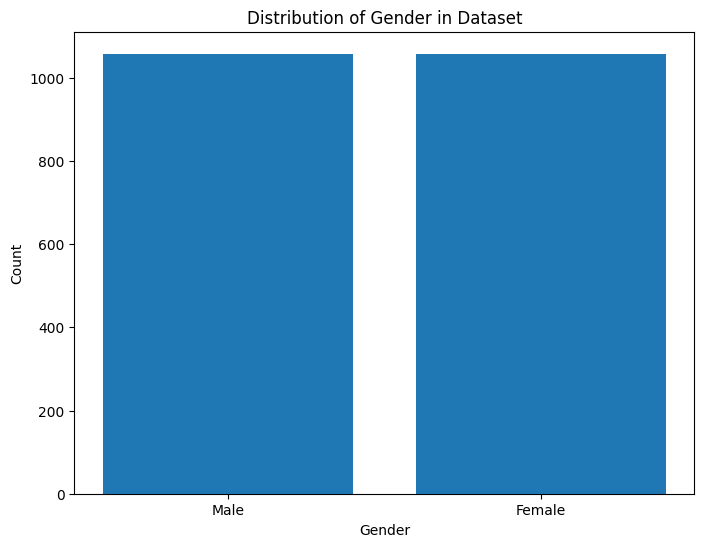

In [55]:
# Assuming 'category_counts' is the variable containing the distribution of 'Male'
category_counts = df['Male'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Gender in Dataset")
plt.show()

In [56]:
# prompt: Train, Test, and Validation Split

# Split the data into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Male'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['Male'])  # 0.25 x 0.8 = 0.2

# Print the shapes of the resulting sets
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Testing set shape:", test_df.shape)

# You can now use train_df, val_df, and test_df for training, validation, and testing your model

Training set shape: (1269, 2)
Validation set shape: (423, 2)
Testing set shape: (424, 2)


In [57]:
# prompt: Create Image Data Generators for train and validation data

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_PATH,
    x_col="image_id",
    y_col="Male",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMG_PATH,
    x_col="image_id",
    y_col="Male",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 1269 validated image filenames belonging to 2 classes.
Found 423 validated image filenames belonging to 2 classes.


In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [81]:
# Function to create AlexNet model
def create_alexnet(input_shape=(150, 150, 3), num_classes=1):
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # 3rd, 4th, 5th Convolutional Layers
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))

    # Output Layer (Binary Classification: Male/Female)
    model.add(Dense(num_classes, activation='sigmoid'))

    return model


In [82]:
# Create the AlexNet model
alexnet_model = create_alexnet(input_shape=(150, 150, 3), num_classes=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [83]:
# Compile the model
alexnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
# Display the model architecture
alexnet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 35, 35, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 17, 17, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 17, 17, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 8, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4096)                │       9,441,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1000)                │       4,097,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,067,793 (129.96 MB)

 Trainable params: 34,067,793 (129.96 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# Train the model using the train and validation generators
history = alexnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Adjust the number of epochs as needed
)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.4857 - loss: 0.7820 - val_accuracy: 0.4976 - val_loss: 0.6935
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4688 - loss: 0.6946 - val_accuracy: 0.7143 - val_loss: 0.6856
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


39/39 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4950 - loss: 0.6932 - val_accuracy: 0.4976 - val_loss: 0.6932
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.4688 - loss: 0.6946 - val_accuracy: 0.7143 - val_loss: 0.6898
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.5060 - loss: 0.6936 - val_accuracy: 0.5048 - val_loss: 0.6931
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4375 - loss: 0.6942 - val_accuracy: 0.1429 - val_loss: 0.6991
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4896 - loss: 0.6932 - val_accuracy: 0.5024 - val_loss: 0.6931
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5625 - loss: 0.6931 - val_accuracy: 0.5714 - val_loss: 0.6931
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.4860 - loss: 0.6932 - val_accuracy: 0.5024 - val_loss: 0.6931
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2500 - loss: 0.6965 - val_accuracy: 0.4286 - val_loss: 0.6940

In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [87]:
# Generate predictions for the test data
test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMG_PATH,
    x_col="image_id",
    y_col="Male",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 424 validated image filenames belonging to 2 classes.


In [88]:
# Predict on the test set
test_predictions = alexnet_model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 523ms/step


In [89]:
# Get the true labels from the test set
true_labels = test_generator.classes

In [90]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 50.00%


In [91]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions)

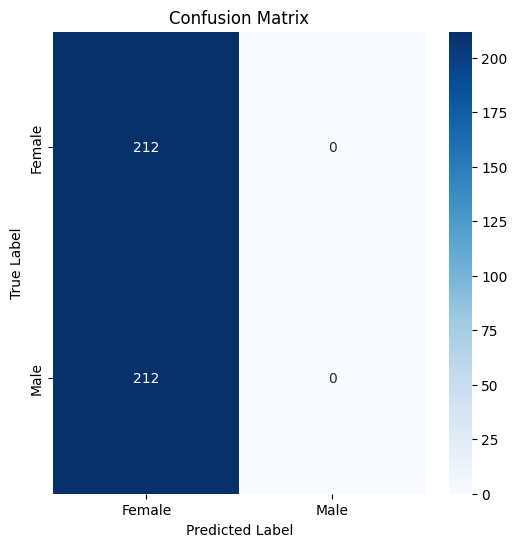

In [92]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [93]:
alexnet_model.save("alexnet_model.h5")

In [94]:
from tensorflow.keras.models import load_model

# Load the saved model from file
loaded_model = load_model("alexnet_model.h5")
print("Model has been loaded from alexnet_model.h5")

# Evaluate the loaded model on test data
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"Loaded model accuracy on test set: {accuracy * 100:.2f}%")

Model has been loaded from alexnet_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - accuracy: 0.4788 - loss: 0.6934
Loaded model accuracy on test set: 50.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


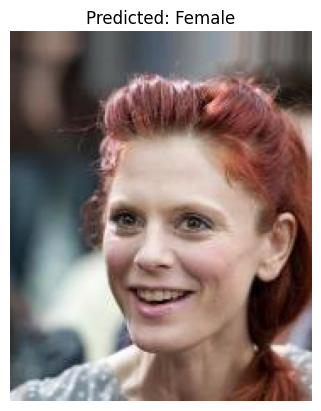

In [101]:
# prompt: gunakan model untuk klasifikasi gambar baru dan tampilkan gambarnya

def classify_and_display_new_image(model, img_path, img_id):
  """
  Classifies a new image using the loaded model and displays it with the prediction.

  Args:
    model: The loaded Keras model.
    img_path: Path to the directory containing the new image.
    img_id: ID or filename of the new image.
  """
  image_path = os.path.join(img_path, img_id)

  try:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure it's in RGB format
    img = cv2.resize(img, (150, 150))  # Resize to match model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    predicted_class = "Male" if prediction[0][0] > 0.5 else "Female"

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

  except FileNotFoundError:
    print(f"Image not found: {image_path}")


# Example usage:
new_image_id = "/content/dataset/img_align_celeba/img_align_celeba/000002.jpg"  # Replace with the ID/filename of your new image
classify_and_display_new_image(loaded_model, IMG_PATH, new_image_id)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


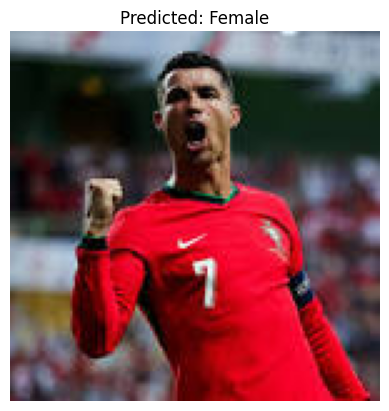

In [104]:
# prompt: gunakan model untuk klasifikasi gambar baru dan tampilkan gambarnya

def classify_and_display_new_image(model, img_path, img_id):
  """
  Classifies a new image using the loaded model and displays it with the prediction.

  Args:
    model: The loaded Keras model.
    img_path: Path to the directory containing the new image.
    img_id: ID or filename of the new image.
  """
  image_path = os.path.join(img_path, img_id)

  try:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure it's in RGB format
    img = cv2.resize(img, (150, 150))  # Resize to match model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    predicted_class = "Male" if prediction[0][0] > 0.5 else "Female"

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

  except FileNotFoundError:
    print(f"Image not found: {image_path}")


# Example usage:
new_image_id = "/content/download.jpg"  # Replace with the ID/filename of your new image
classify_and_display_new_image(loaded_model, IMG_PATH, new_image_id)